# Heavy Hexagonal Lattice
The Heavy Hexagonal Lattice

In [53]:
# Import Libraries

import numpy as np
import scipy
import matplotlib.pyplot as plt
from pprint import pprint

np.set_printoptions(precision=5, suppress=True, linewidth=100)

import tenpy
import tenpy.linalg.np_conserved as npc
from tenpy.algorithms import tebd, dmrg, tdvp
from tenpy.networks.site import SpinHalfSite, SpinSite, FermionSite
from tenpy.networks.mps import MPS
from tenpy.models.tf_ising import TFIChain
from tenpy.algorithms import dmrg
from tenpy.algorithms.dmrg import DMRGEngine
from tenpy.algorithms.exact_diag import ExactDiag

tenpy.tools.misc.setup_logging(to_stdout="INFO")

import tenpy.linalg.np_conserved as npc
from tenpy.networks.site import SpinHalfSite
from tenpy.networks.mps import MPS
from tenpy.networks.mpo import MPO
from tenpy.networks.site import SpinSite
from tenpy.models.lattice import Chain
from tenpy.models.model import CouplingModel, NearestNeighborModel, MPOModel, CouplingMPOModel
from tenpy.models.spins import SpinModel
from tenpy.models import Lattice

Matching the syntax of Tenpy source code: 

In [2]:
def _parse_sites(sites, expected_number):
    try: 
        iter(sites)
    except TypeError:
        return [sites] * expected_number
    if len(sites) != expected_number:
        raise ValueError("need to specify a single site or exactly {0:d}, got {1:d}".format(expected_number, len(sites)))
    return sites

In [3]:
class HeavyHex(Lattice):
    dim = 2
    Lu = 5

    def __init__(self, Lx, Ly, sites, **kwargs):
        sites = _parse_sites(sites, 5)
        a1 = np.array([np.sqrt(3), 0.0])        a1 = np.array([np.sqrt(3), 0.0])
        a2 = np.array([np.sqrt(3)/2, 3/2])
        basis = np.array([a1, a2])
        a2 = np.array([np.sqrt(3)/2, 3/2])
        basis = np.array([a1, a2])
        
        A = np.array([0.0, 0.0])
        C = np.array([0.5 * np.sqrt(3), 0.5])
        B = (A + C) / 2
        D = (A + C + a1) / 2
        E = (A + C + a2) / 2
        pos = [A, B, C, D, E]
        
        kwargs.setdefault("basis", basis)
        kwargs.setdefault("positions", pos)

        NN = []
        
        NN.append((0, 1, np.array([0, 0])))
        NN.append((1, 2, np.array([0, 0])))
        NN.append((2, 3, np.array([0, 0])))
        NN.append((2, 4, np.array([0, 0])))
        
        NN.append((3, 0, np.array([1, 0])))
        NN.append((4, 0, np.array([0, 1])))
        
        kwargs.setdefault("pairs", {})
        kwargs["pairs"].setdefault("nearest_neighbors", NN)

        nNN = []
        
        nNN.append((1, 3, np.array([0, 0])))
        nNN.append((1, 4, np.array([0, 0])))
        nNN.append((3, 4, np.array([0, 0])))

        nNN.append((3, 1, np.array([1, 0])))
        nNN.append((4, 1, np.array([0, 1])))
        nNN.append((4, 3, np.array([-1, 1])))
        kwargs["pairs"].setdefault("next_nearest_neighbors", nNN)

        nnNN = []
        nnNN.append((0, 2, np.array([0, 0])))
        
        nnNN.append((2, 0, np.array([1, 0])))
        nnNN.append((2, 0, np.array([0, 1])))
        kwargs["pairs"].setdefault("next_next_nearest_neighbors", nnNN)
        
        Lattice.__init__(self, [Lx, Ly], sites, **kwargs)

In [4]:
hhex = HeavyHex(4, 4, None)

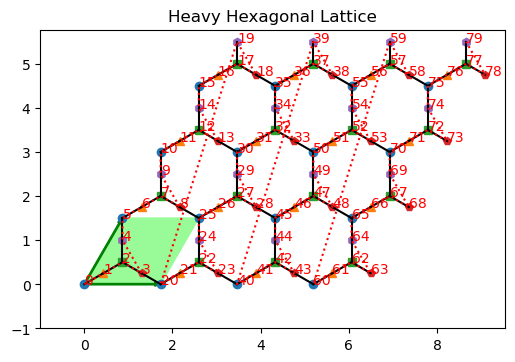

In [5]:
plt.figure(figsize=(6, 6))
plt.title("Heavy Hexagonal Lattice")
ax = plt.gca()
hhex.plot_sites(ax)
hhex.plot_coupling(ax)
hhex.plot_order(ax, linestyle=":")
hhex.plot_basis(ax)
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

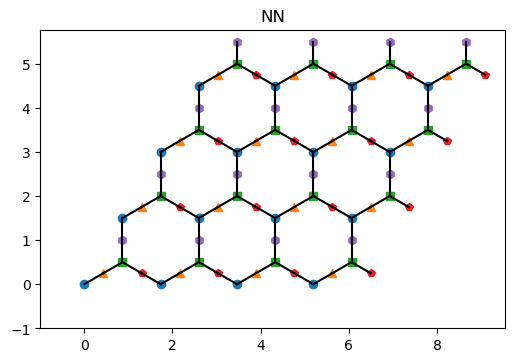

In [6]:
plt.figure(figsize=(6, 6))
plt.title("NN")
ax = plt.gca()
hhex.plot_sites(ax)
hhex.plot_coupling(ax)
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

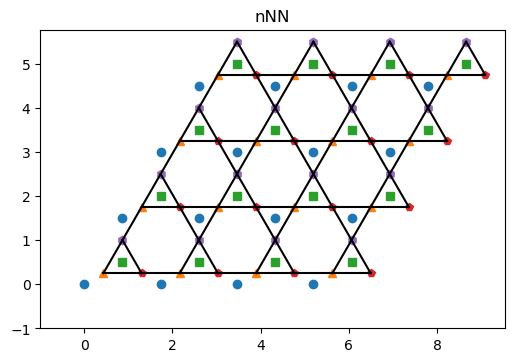

In [7]:
plt.figure(figsize=(6, 6))
plt.title("nNN")
ax = plt.gca()
hhex.plot_sites(ax)
hhex.plot_coupling(ax, coupling=hhex.pairs["next_nearest_neighbors"])
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

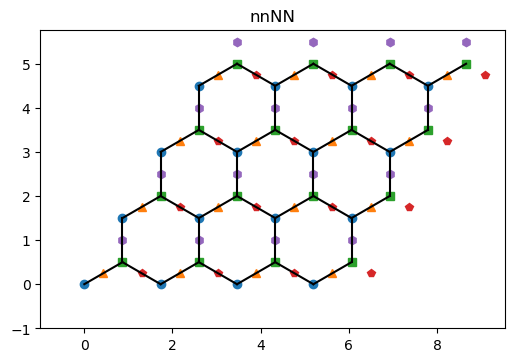

In [8]:
plt.figure(figsize=(6, 6))
plt.title("nnNN")
ax = plt.gca()
hhex.plot_sites(ax)
hhex.plot_coupling(ax, coupling=hhex.pairs["next_next_nearest_neighbors"])
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

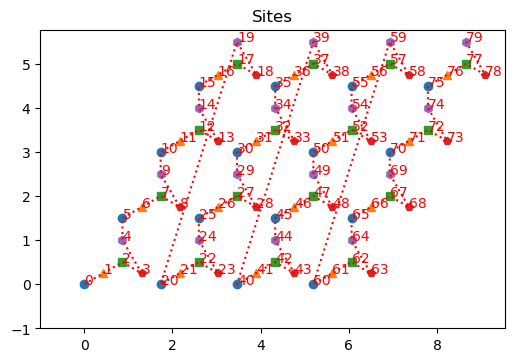

In [9]:
plt.figure(figsize=(6, 6))
plt.title("Sites")
ax = plt.gca()
hhex.plot_sites(ax)
hhex.plot_order(ax, linestyle=":")
ax.set_aspect("equal")
ax.set_xlim(-1)
ax.set_ylim(-1)
plt.show()

In [10]:
class IsingModel(CouplingMPOModel):
    def init_sites(self, model_params):
        conserve = model_params.get("conserve", "best")
        if conserve == "best":
            if model_params.get("hx", 0) == 0:
                conserve = "Sz"
            else:
                conserve = None
        return SpinHalfSite(conserve=conserve)

In [11]:
class HeavyHexModel(IsingModel):
    default_lattice = HeavyHex
    force_default_lattice = True

    def init_sites(self, model_params):
        site = IsingModel.init_sites(self, model_params)
        return (site, site, site, site, site)

    def init_terms(self, model_params):
        J1 = model_params.get("J1", 1)
        J2 = model_params.get("J2", 1)
        J3 = model_params.get("J3", 1)

        for u1, u2, dx in self.lat.pairs["nearest_neighbors"]:
            self.add_coupling(J1, u1, "Sz", u2, "Sz", dx)

        for u1, u2, dx in self.lat.pairs["next_nearest_neighbors"]:
            self.add_coupling(J2, u1, "Sz", u2, "Sz", dx)

        for u1, u2, dx in self.lat.pairs["next_next_nearest_neighbors"]:
            self.add_coupling(J3, u1, "Sz", u2, "Sz", dx)

For the sanity of my computer let's only run ED on a single cell of Heavy Hexagonal Lattice...

In [12]:
hhex_model = HeavyHexModel({"Lx": 2, "Ly": 1, "J1": 1, "J2": 0, "J3": 0, 'bc_MPS': 'finite'})

INFO    : HeavyHexModel: reading 'bc_MPS'='finite'
INFO    : HeavyHexModel: reading 'Lx'=2
INFO    : HeavyHexModel: reading 'Ly'=1
INFO    : HeavyHexModel: reading 'J1'=1
INFO    : HeavyHexModel: reading 'J2'=0
INFO    : HeavyHexModel: reading 'J3'=0


In [13]:
hhex_ed = ExactDiag(hhex_model)
hhex_ed.build_full_H_from_mpo()
hhex_ed.full_diagonalization()

In [14]:
E0, psi0 = hhex_ed.groundstate()
E0

-2.75

In [15]:
psi0

<npc.Array shape=(1024,) labels=['ps']>

I'm not sure how to convert this psi0 into an MPO...

In [16]:
J2_arr = np.linspace(0, 2, 1000)
E0_arr = np.array([])
Sz_arr = np.array([])

for J2 in J2_arr:
    hhex_model = HeavyHexModel({"Lx": 1, "Ly": 1, "J1": 1, "J2": J2, "J3": 0, 'bc_MPS': 'finite'})
    hhex_ed = ExactDiag(hhex_model)
    hhex_ed.build_full_H_from_mpo()
    hhex_ed.full_diagonalization()
    E0, psi0 = hhex_ed.groundstate()
    E0_arr = np.append(E0_arr, E0)

INFO    : HeavyHexModel: reading 'bc_MPS'='finite'
INFO    : HeavyHexModel: reading 'Lx'=1
INFO    : HeavyHexModel: reading 'Ly'=1
INFO    : HeavyHexModel: reading 'J1'=1
INFO    : HeavyHexModel: reading 'J2'=0.0
INFO    : HeavyHexModel: reading 'J3'=0
INFO    : HeavyHexModel: reading 'bc_MPS'='finite'
INFO    : HeavyHexModel: reading 'Lx'=1
INFO    : HeavyHexModel: reading 'Ly'=1
INFO    : HeavyHexModel: reading 'J1'=1
INFO    : HeavyHexModel: reading 'J2'=0.002002002002002002
INFO    : HeavyHexModel: reading 'J3'=0
INFO    : HeavyHexModel: reading 'bc_MPS'='finite'
INFO    : HeavyHexModel: reading 'Lx'=1
INFO    : HeavyHexModel: reading 'Ly'=1
INFO    : HeavyHexModel: reading 'J1'=1
INFO    : HeavyHexModel: reading 'J2'=0.004004004004004004
INFO    : HeavyHexModel: reading 'J3'=0
INFO    : HeavyHexModel: reading 'bc_MPS'='finite'
INFO    : HeavyHexModel: reading 'Lx'=1
INFO    : HeavyHexModel: reading 'Ly'=1
INFO    : HeavyHexModel: reading 'J1'=1
INFO    : HeavyHexModel: reading 'J2

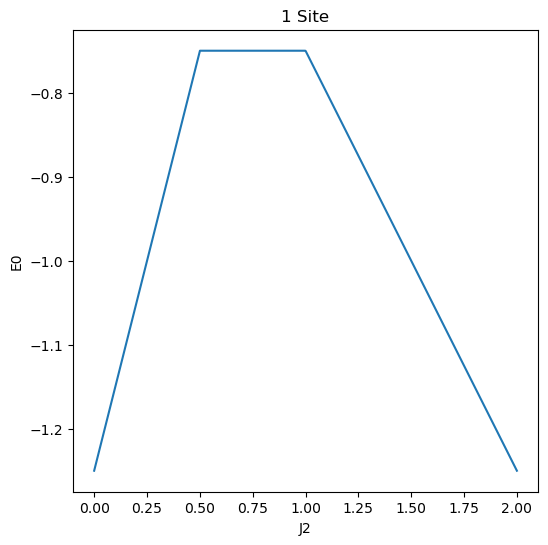

In [17]:
plt.figure(figsize=(6, 6))
plt.plot(J2_arr, E0_arr)
plt.title("1 Site")
plt.xlabel("J2")
plt.ylabel("E0")
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (0,)

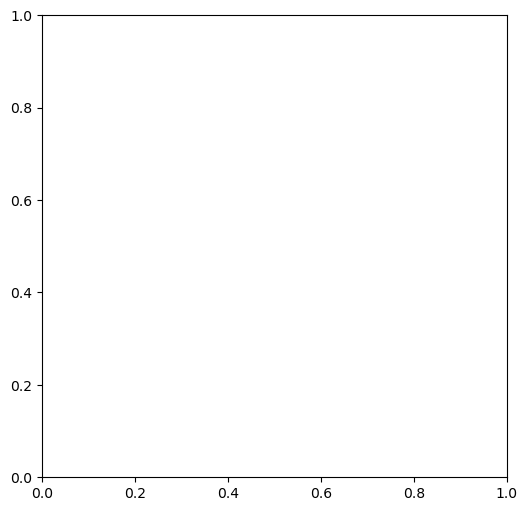

In [18]:
plt.figure(figsize=(6, 6))
plt.plot(J2_arr, Sz_arr)
plt.title("1 Site")
plt.xlabel("J2")
plt.ylabel("Sz")
plt.show()

In [ ]:
psi = MPS.from_dense(psi0, [site] * 5, bc="finite")

In [ ]:
psi0.

In [ ]:
hhex_model = HeavyHexModel({"Lx": 1, "Ly": 2, "J1": 1, "J2": 0, "J3": 0, 'bc_MPS': 'finite'})
hhex_ed = exact_diag.ExactDiag(hhex_model)
hhex_ed.build_full_H_from_mpo()
hhex_ed.full_diagonalization()
E0, psi0 = hhex_ed.groundstate()
# E0_arr = np.append(E0_arr, E0)

psi0_mps = hhex_ed.full_to_mps(psi0)
# Sz_arr = np.append(Sz_arr, Sz)

In [ ]:
print(psi0)

In [ ]:
psi0_mps

In [ ]:
MPS.from_full([SpinHalfSite(conserve="Sz")] * 1024, psi0)

In [ ]:
hhex_ed.V

In [ ]:
psi0.to_ndarray()

In [ ]:
np.mean(psi0_mps.expectation_value("Sz"))

INFO    : HeavyHexModel: reading 'bc_MPS'='infinite'
INFO    : HeavyHexModel: reading 'Lx'=2
INFO    : HeavyHexModel: reading 'Ly'=2
INFO    : HeavyHexModel: reading 'J1'=1
INFO    : HeavyHexModel: reading 'J2'=0
INFO    : HeavyHexModel: reading 'J3'=0


In [58]:
J2_arr = np.linspace(0, 1, 100)
E0_arr = np.array([])

for J2 in J2_arr:
    hhex_model = HeavyHexModel({"Lx": 2, "Ly": 2, "J1": 1, "J2": J2, "J3": 1, 'bc_MPS': 'infinite'})
    p_state = ['up', 'up', 'up', 'up', 'up'] * (hhex_model.lat.N_sites // 5)
    psi = MPS.from_product_state(hhex_model.lat.mps_sites(), p_state, "infinite")
    algorithm_params = {'trunc_params': {'chi_max': 100, 'svd_min': 1e-10}, "mixer": True}
    eng = dmrg.TwoSiteDMRGEngine(psi, hhex_model, algorithm_params)
    info = eng.run()

INFO    : HeavyHexModel: reading 'bc_MPS'='infinite'
INFO    : HeavyHexModel: reading 'Lx'=2
INFO    : HeavyHexModel: reading 'Ly'=2
INFO    : HeavyHexModel: reading 'J1'=1
INFO    : HeavyHexModel: reading 'J2'=0.0
INFO    : HeavyHexModel: reading 'J3'=1
INFO    : TwoSiteDMRGEngine: subconfig 'trunc_params'=Config(<2 options>, 'trunc_params')
INFO    : start environment_sweep
INFO    : trunc_params: reading 'chi_max'=100
INFO    : trunc_params: reading 'svd_min'=1e-10
INFO    : TwoSiteDMRGEngine: reading 'mixer'=True
INFO    : activate DensityMatrixMixer with initial amplitude 1e-05
INFO    : Running sweep with optimization
INFO    : start environment_sweep
INFO    : checkpoint after sweep 10
energy=0.4500000000000000, max S=-0.0000000000000000, age=660, norm_err=0.0e+00
Current memory usage 630.6MB, wall time: 1.2s
Delta E = nan, Delta S = 0.0000e+00 (per sweep)
max trunc_err = 0.0000e+00, max E_trunc = 0.0000e+00
chi: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
INFO 

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

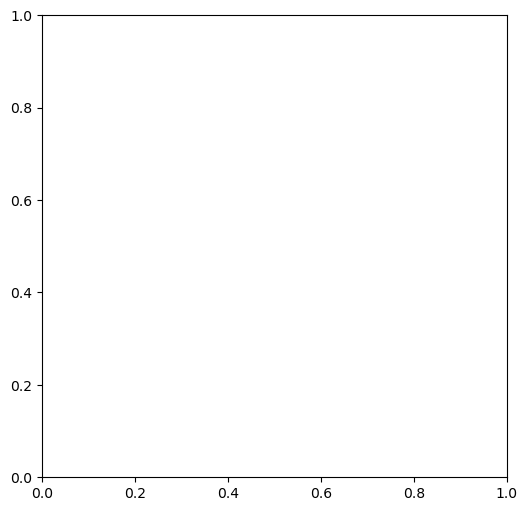

In [59]:
plt.figure(figsize=(6, 6))
plt.plot(J2_arr, E0_arr)
plt.title("Site")
plt.xlabel("J2")
plt.ylabel("E0")
plt.show()